In [1]:
# Mount Google Drive (update path if needed)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ================================================
# 📌 0. Install required libraries
# ================================================
!pip install pandas numpy matplotlib scikit-learn tensorflow

In [3]:
# ================================================
# 1) Imports
# ================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Layer, Multiply, Permute, RepeatVector, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from google.colab import files
import os

In [4]:
# ================================================
# 2) Upload dataset (advanced_synthetic_supplychain_timeseries.csv)
# ================================================
# print("Upload your CSV file now (advanced dataset recommended).")
# uploaded = files.upload()
# fname = list(uploaded.keys())[0]
# df = pd.read_csv(fname)
df = pd.read_csv("/content/drive/MyDrive/AmulSynDataset/advanced_synthetic_supplychain_timeseries.csv")
# print("Loaded:", fname)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['branchcode', 'materialcode', 'date']).reset_index(drop=True)
df.head()

,date,branchcode,materialcode,sales_qty,stock_on_hand,intransit_qty,pending_po_qty,lead_time_days,stockout_flag
0,2022-01-01,GC01,SKU_A,19,519,99,29,6,0
1,2022-01-02,GC01,SKU_A,8,431,121,66,10,0
2,2022-01-03,GC01,SKU_A,24,500,113,70,12,0
3,2022-01-04,GC01,SKU_A,16,563,45,69,7,0
4,2022-01-05,GC01,SKU_A,42,409,71,60,8,0


In [5]:
# ================================================
# 3) Feature engineering
# ================================================
# Add cyclical date features (day-of-year and weekday)
df['day_of_year'] = df['date'].dt.dayofyear
df['dow'] = df['date'].dt.weekday
df['month'] = df['date'].dt.month

# cyclical transforms
df['sin_doy'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
df['cos_doy'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)
df['sin_dow'] = np.sin(2 * np.pi * df['dow'] / 7)
df['cos_dow'] = np.cos(2 * np.pi * df['dow'] / 7)

# festival flag (example festivals used previously)
festivals = ['2022-10-15','2023-10-24','2024-11-01']
festivals = [pd.to_datetime(d) for d in festivals]
def fest_flag(date):
    for f in festivals:
        if abs((date - f).days) <= 7:  # 7-day window
            return 1
    return 0
df['festival_flag'] = df['date'].apply(fest_flag)

# Encode categorical features
le_branch = LabelEncoder()
df['branch_enc'] = le_branch.fit_transform(df['branchcode'])
le_sku = LabelEncoder()
df['sku_enc'] = le_sku.fit_transform(df['materialcode'])

# target
TARGET = 'sales_qty'

# Fillna if any (small safety)
df[['stock_on_hand','intransit_qty','pending_po_qty','lead_time_days']] = df[[
    'stock_on_hand','intransit_qty','pending_po_qty','lead_time_days']].fillna(0)


In [6]:
# ================================================
# 4) Build sequences per (branch, sku)
#    - This preserves each series' temporal structure
# ================================================
SEQ_LEN = 60   # lookback window (days)
FEATURES = [
    'stock_on_hand','intransit_qty','pending_po_qty','lead_time_days',
    'sin_doy','cos_doy','sin_dow','cos_dow','festival_flag',
    'branch_enc','sku_enc'
]

# We'll scale features and target separately
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Fit scalers on entire dataset (could be fit on train only; for brevity we do entire)
df_features = df[FEATURES].astype(float)
df_target = df[[TARGET]].astype(float)

df_features_scaled = pd.DataFrame(feature_scaler.fit_transform(df_features), columns=FEATURES)
df_target_scaled = pd.DataFrame(target_scaler.fit_transform(df_target), columns=[TARGET])

# place scaled columns back into df_sc
df_sc = df.copy().reset_index(drop=True)
for c in FEATURES:
    df_sc[c] = df_features_scaled[c].values
df_sc[TARGET] = df_target_scaled[TARGET].values

# Create sequences
X_list = []
y_list = []

grouped = df_sc.groupby(['branchcode','materialcode'])
for (b, m), g in grouped:
    g = g.sort_values('date').reset_index(drop=True)
    if len(g) <= SEQ_LEN:
        continue
    feat_arr = g[FEATURES].values
    targ_arr = g[TARGET].values
    for i in range(SEQ_LEN, len(g)):
        X_list.append(feat_arr[i-SEQ_LEN:i])
        y_list.append(targ_arr[i])  # next-day target

X = np.array(X_list)
y = np.array(y_list).reshape(-1,1)

print("Total sequences:", X.shape, "Targets:", y.shape)

# Train/test split by time (80/20)
split_idx = int(0.8 * len(X))
idxs = np.arange(len(X))
np.random.seed(123)
# Keep chronological split to prevent leakage — but sequences come from different series; a mixed split is fine here
# we'll shuffle then split for model training robustness
np.random.shuffle(idxs)
train_idx = idxs[:split_idx]
test_idx = idxs[split_idx:]

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Total sequences: (25900, 60, 11) Targets: (25900, 1)
Train shape: (20720, 60, 11) (20720, 1)
Test shape: (5180, 60, 11) (5180, 1)


In [7]:
# ================================================
# 5) Attention Layer (simple Bahdanau-style)
# ================================================
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], input_shape[-1]), initializer="random_normal", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[-1],), initializer="zeros", trainable=True)
        self.u = self.add_weight(name="att_u", shape=(input_shape[-1],1), initializer="random_normal", trainable=True)
        super(AttentionLayer, self).build(input_shape)
    def call(self, inputs):
        # inputs: (batch_size, time_steps, features)
        u_it = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)  # (batch, time, features)
        ait = tf.tensordot(u_it, self.u, axes=1)  # (batch, time, 1)
        ait = tf.squeeze(ait, -1)  # (batch, time)
        a = tf.nn.softmax(ait)  # (batch, time)
        a = tf.expand_dims(a, -1)  # (batch, time, 1)
        weighted_input = inputs * a  # (batch, time, features)
        output = tf.reduce_sum(weighted_input, axis=1)  # (batch, features)
        return output


In [8]:
# ================================================
# 6) Build the Model: Multi-layer Bidirectional LSTM + Attention
# ================================================
n_features = X_train.shape[2]
input_layer = Input(shape=(SEQ_LEN, n_features))

# Stacked BiLSTM layers
x = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
x = Dropout(0.2)(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Dropout(0.2)(x)
x = Bidirectional(LSTM(32, return_sequences=True))(x)
x = Dropout(0.15)(x)

# Attention to summarize time dimension
att_out = AttentionLayer()(x)  # shape -> (batch, features)

# Dense head
h = Dense(64, activation='relu')(att_out)
h = Dropout(0.2)(h)
h = Dense(32, activation='relu')(h)
out = Dense(1, activation='linear')(h)

model = Model(inputs=input_layer, outputs=out)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 11)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 60, 256)        │       143,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 60, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 60, 64)         │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ (None, 64)             │         4,224 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 359,425 (1.37 MB)

 Trainable params: 359,425 (1.37 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# ================================================
# 7) Callbacks
# ================================================
os.makedirs('models', exist_ok=True)
checkpoint_path = "models/bilstm_attention_best.h5"

callbacks = [
    EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, verbose=1, min_lr=1e-6),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
]

In [10]:
# ================================================
# 8) Train
# ================================================
history = model.fit(
    X_train, y_train,
    validation_split=0.15,
    epochs=80,
    batch_size=128,
    callbacks=callbacks,
    verbose=2
)


Epoch 1/80

Epoch 1: val_loss improved from inf to 0.01407, saving model to models/bilstm_attention_best.h5


138/138 - 14s - 100ms/step - loss: 0.0192 - mae: 0.0958 - val_loss: 0.0141 - val_mae: 0.0890 - learning_rate: 1.0000e-03
Epoch 2/80

Epoch 2: val_loss improved from 0.01407 to 0.00935, saving model to models/bilstm_attention_best.h5


138/138 - 4s - 31ms/step - loss: 0.0101 - mae: 0.0741 - val_loss: 0.0093 - val_mae: 0.0724 - learning_rate: 1.0000e-03
Epoch 3/80

Epoch 3: val_loss improved from 0.00935 to 0.00931, saving model to models/bilstm_attention_best.h5


138/138 - 4s - 27ms/step - loss: 0.0087 - mae: 0.0703 - val_loss: 0.0093 - val_mae: 0.0726 - learning_rate: 1.0000e-03
Epoch 4/80

Epoch 4: val_loss did not improve from 0.00931
138/138 - 4s - 26ms/step - loss: 0.0089 - mae: 0.0704 - val_loss: 0.0096 - val_mae: 0.0734 - learning_rate: 1.0000e-03
Epoch 5/80

Epoch 5: val_loss did not improve from 0.00931
138/138 - 4s - 31ms/step - loss: 0.0083 - mae: 0.0687 - val_loss: 0.0099 - val_mae: 0.0735 - learning_rate: 1.0000e-03
Epoch 6/80

Epoch 6: val_loss did not improve from 0.00931
138/138 - 4s - 26ms/step - loss: 0.0083 - mae: 0.0685 - val_loss: 0.0106 - val_mae: 0.0778 - learning_rate: 1.0000e-03
Epoch 7/80

Epoch 7: val_loss did not improve from 0.00931
138/138 - 4s - 26ms/step - loss: 0.0085 - mae: 0.0689 - val_loss: 0.0118 - val_mae: 0.0791 - learning_rate: 1.0000e-03
Epoch 8/80

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 8: val_loss did not improve from 0.00931
138/138 - 4s - 32ms/step - loss: 

138/138 - 4s - 28ms/step - loss: 0.0078 - mae: 0.0671 - val_loss: 0.0089 - val_mae: 0.0708 - learning_rate: 5.0000e-04
Epoch 10/80

Epoch 10: val_loss did not improve from 0.00887
138/138 - 4s - 26ms/step - loss: 0.0078 - mae: 0.0670 - val_loss: 0.0114 - val_mae: 0.0809 - learning_rate: 5.0000e-04
Epoch 11/80

Epoch 11: val_loss did not improve from 0.00887
138/138 - 4s - 30ms/step - loss: 0.0080 - mae: 0.0675 - val_loss: 0.0102 - val_mae: 0.0782 - learning_rate: 5.0000e-04
Epoch 12/80

Epoch 12: val_loss did not improve from 0.00887
138/138 - 4s - 29ms/step - loss: 0.0076 - mae: 0.0667 - val_loss: 0.0110 - val_mae: 0.0804 - learning_rate: 5.0000e-04
Epoch 13/80

Epoch 13: val_loss did not improve from 0.00887
138/138 - 4s - 26ms/step - loss: 0.0080 - mae: 0.0672 - val_loss: 0.0098 - val_mae: 0.0750 - learning_rate: 5.0000e-04
Epoch 14/80

Epoch 14: val_loss did not improve from 0.00887
138/138 - 4s - 27ms/step - loss: 0.0080 - mae: 0.0675 - val_loss: 0.0130 - val_mae: 0.0822 - learnin

162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
Test MSE: 135.5271  MAE: 8.8333  RMSE: 11.6416


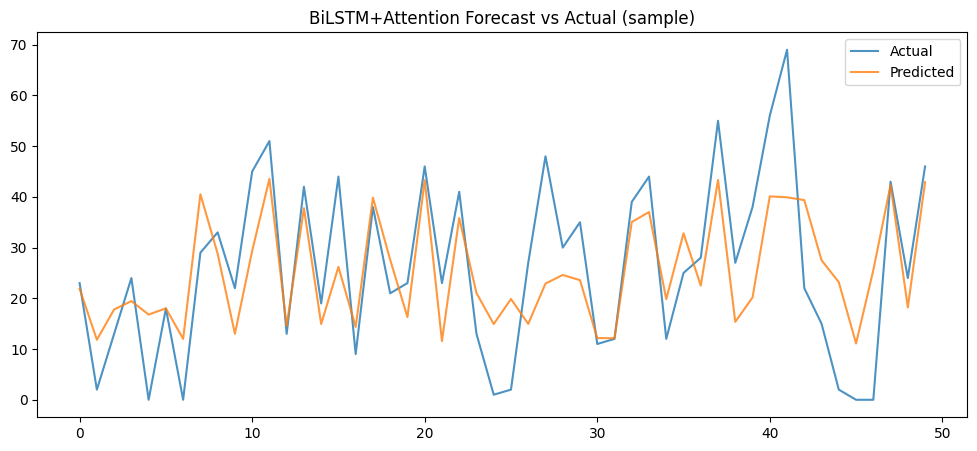

In [13]:
# ================================================
# 9) Evaluate & Inverse-transform predictions
# ================================================
y_pred_s = model.predict(X_test)

# invert scaling
y_test_inv = target_scaler.inverse_transform(y_test)
y_pred_inv = target_scaler.inverse_transform(y_pred_s)

mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mse = mean_squared_error(y_test_inv, y_pred_inv)
print(f"Test MSE: {mse:.4f}  MAE: {mae:.4f}  RMSE: {rmse:.4f}")

# sample plot (first 500 points)
n_plot = min(50, len(y_test_inv))
plt.figure(figsize=(12,5))
plt.plot(y_test_inv[:n_plot], label='Actual', alpha=0.8)
plt.plot(y_pred_inv[:n_plot], label='Predicted', alpha=0.8)
plt.legend()
plt.title("BiLSTM+Attention Forecast vs Actual (sample)")
plt.show()


In [14]:
# ================================================
# 10) Save scalers & model (downloadable)
# ================================================
import os
import pickle

# 2. Define the path and create the directory if it doesn't exist
save_path = '/content/drive/MyDrive/multiLayerLSTMAmulModels'
os.makedirs(save_path, exist_ok=True)

# 3. Save the Keras/TensorFlow model
model_file = os.path.join(save_path, "bilstm_attention_final.h5")
model.save(model_file)
print(f"Model saved to {model_file}")

# 4. Save the scalers using pickle to the same Drive path
feature_scaler_file = os.path.join(save_path, 'feature_scaler.pkl')
target_scaler_file = os.path.join(save_path, 'target_scaler.pkl')

with open(feature_scaler_file, 'wb') as f:
    pickle.dump(feature_scaler, f)
print(f"Feature scaler saved to {feature_scaler_file}")

with open(target_scaler_file, 'wb') as f:
    pickle.dump(target_scaler, f)
print(f"Target scaler saved to {target_scaler_file}")


Model saved to /content/drive/MyDrive/multiLayerLSTMAmulModels/bilstm_attention_final.h5
Feature scaler saved to /content/drive/MyDrive/multiLayerLSTMAmulModels/feature_scaler.pkl
Target scaler saved to /content/drive/MyDrive/multiLayerLSTMAmulModels/target_scaler.pkl


In [ ]:
# ================================================
# END
# ================================================